# Calibration Analysis

In [1]:
%matplotlib inline

*Libraries*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

*Global parameters*

In [3]:
scenario = 'sc3'

*Paths*

In [4]:
data_file = '../data/scenarios/'

*Ignore warnings*

In [5]:
import warnings
warnings.filterwarnings("ignore")

## 1. Preprocessing

*Read file*

In [6]:
results = pd.read_csv('{}{}.csv'.format(data_file, scenario))

## 2. Visualization

*Plot raw incidence rate errors*

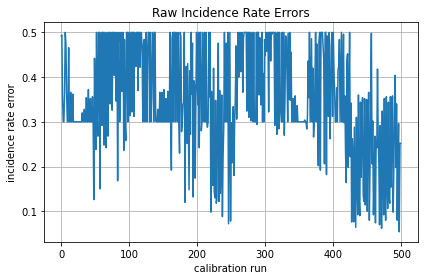

In [7]:
plt.figure()
plt.plot(results['IrE'])
plt.ylabel('incidence rate error')
plt.xlabel('calibration run')
plt.title('Raw Incidence Rate Errors')
plt.grid()
plt.tight_layout()
plt.show()

*Plot raw exposure rate errors*

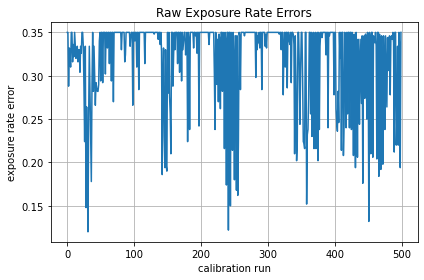

In [8]:
plt.figure()
plt.plot(results['ErE'])
plt.ylabel('exposure rate error')
plt.xlabel('calibration run')
plt.title('Raw Exposure Rate Errors')
plt.grid()
plt.tight_layout()
plt.show()

*Plot rewards*

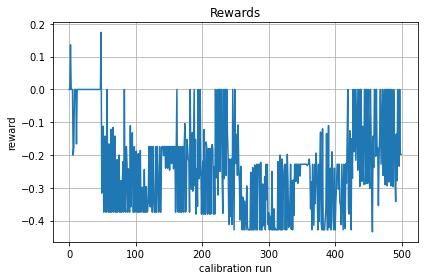

In [9]:
plt.figure()
plt.plot(results['Reward'])
plt.ylabel('reward')
plt.xlabel('calibration run')
plt.title('Rewards')
plt.grid()
plt.tight_layout()
plt.show()

## 3. Decomposition

*Decompose incidence rate errors*

In [10]:
incidence_rate_errors = seasonal_decompose(results['IrE'], period=20, model='additive')

*Plot IrE's decomposition*

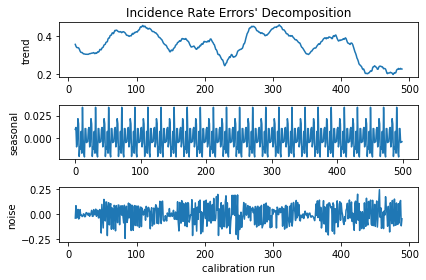

In [11]:
fig, axs = plt.subplots(3)
plt.xlabel('calibration run')
axs[0].plot(incidence_rate_errors.trend)
axs[0].set_ylabel('trend')
axs[0].title.set_text("Incidence Rate Errors' Decomposition")
axs[1].plot(incidence_rate_errors.seasonal)
axs[1].set_ylabel('seasonal')
axs[2].plot(incidence_rate_errors.resid)
axs[2].set_ylabel('noise')
plt.tight_layout()
plt.show()

*Decompose exposure rate errors*

In [12]:
exposure_rate_errors = seasonal_decompose(results['ErE'], period=20, model='additive')

*Plot ErE's decomposition*

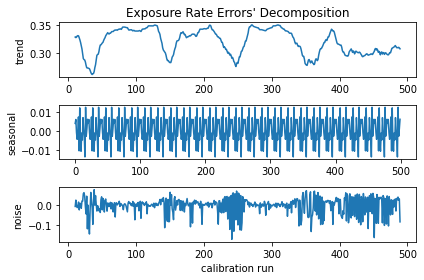

In [13]:
fig, axs = plt.subplots(3)
plt.xlabel('calibration run')
axs[0].plot(exposure_rate_errors.trend)
axs[0].set_ylabel('trend')
axs[0].title.set_text("Exposure Rate Errors' Decomposition")
axs[1].plot(exposure_rate_errors.seasonal)
axs[1].set_ylabel('seasonal')
axs[2].plot(exposure_rate_errors.resid)
axs[2].set_ylabel('noise')
plt.tight_layout()
plt.show()

## 4. Statistical analysis

*Remove NaN values*

In [14]:
ire_trend = pd.Series([e for e in incidence_rate_errors.trend if np.isnan(e) == False])

*Plot errors' trend*

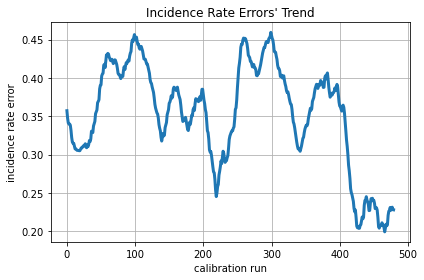

In [15]:
plt.figure()
plt.plot(ire_trend, linewidth=3)
plt.ylabel('incidence rate error')
plt.xlabel('calibration run')
plt.title("Incidence Rate Errors' Trend")
plt.tight_layout()
plt.grid()
plt.show()

*Plot error's lag scatter*

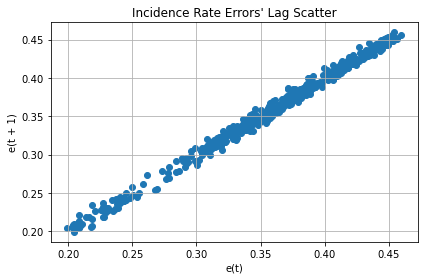

In [16]:
plt.figure()
pd.plotting.lag_plot(ire_trend)
plt.ylabel('e(t + 1)')
plt.xlabel('e(t)')
plt.title("Incidence Rate Errors' Lag Scatter")
plt.tight_layout()
plt.grid()
plt.show()

*Plot errors's autocorrelation*

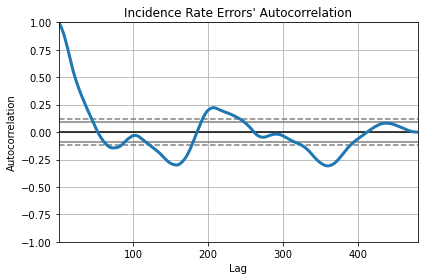

In [17]:
plt.figure()
pd.plotting.autocorrelation_plot(ire_trend, linewidth=3)
plt.title("Incidence Rate Errors' Autocorrelation")
plt.tight_layout()
plt.show()

*Apply moving average smoothing*

In [18]:
ire_rolling = ire_trend.rolling(window=20)
ire_rolling_mean = ire_rolling.mean()
ire_rolling_mean = np.array([e for e in ire_rolling_mean if np.isnan(e) == False])

*Plot smoothed error trend*

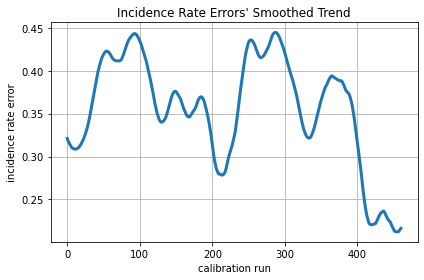

In [19]:
plt.figure()
plt.plot(ire_rolling_mean, linewidth=3)
plt.ylabel('incidence rate error')
plt.xlabel('calibration run')
plt.title("Incidence Rate Errors' Smoothed Trend")
plt.grid()
plt.tight_layout()
plt.show()

*Apply Augmented Dickey-Fuller test*

In [20]:
adf_test = adfuller(ire_rolling_mean)
print('p-value = {:0.2f}'.format(adf_test[1]))

p-value = 0.48


*Apply Kwiatkowski-Phillips-Schmidt-Shin test*

In [21]:
kpss_test = kpss(ire_rolling_mean)
print('p-value = {:0.2f}'.format(kpss_test[1]))

p-value = 0.02


*Compute log-ratios*

In [22]:
log_ratios = np.log(ire_rolling_mean[1:]) - np.log(ire_rolling_mean[:-1])

*Plot log-ratios*

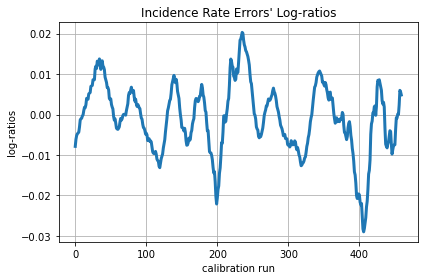

In [23]:
plt.figure()
plt.plot(log_ratios, linewidth=3)
plt.ylabel('log-ratios')
plt.xlabel('calibration run')
plt.title("Incidence Rate Errors' Log-ratios")
plt.grid()
plt.tight_layout()
plt.show()

*Plot log-ratios' histogram*

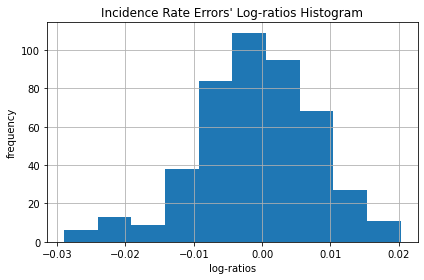

In [24]:
plt.figure()
plt.hist(log_ratios)
plt.xlabel('log-ratios')
plt.ylabel('frequency')
plt.title("Incidence Rate Errors' Log-ratios Histogram")
plt.grid()
plt.tight_layout()
plt.show()

*Plot log-ratios' QQ-plot*

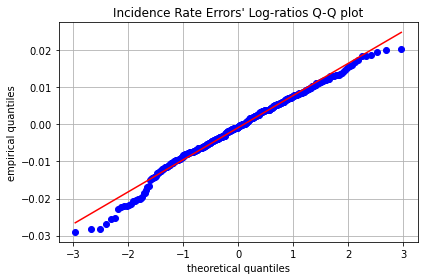

In [25]:
plt.figure()
stats.probplot(log_ratios, dist='norm', plot=plt)
plt.xlabel('theoretical quantiles')
plt.ylabel('empirical quantiles')
plt.title("Incidence Rate Errors' Log-ratios Q-Q plot")
plt.grid()
plt.tight_layout()
plt.show()

*Apply Kolmogorov-Smirnov test*

In [26]:
_, ks_pval = stats.kstest(log_ratios, 'norm', (np.mean(log_ratios), np.std(log_ratios)))
print('p-value = {:0.2f}'.format(ks_pval))

p-value = 0.49


*Plot log-ratios's autocorrelation*

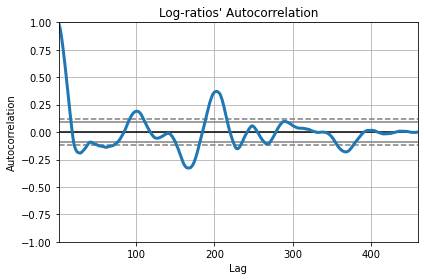

In [27]:
plt.figure()
pd.plotting.autocorrelation_plot(log_ratios, linewidth=3)
plt.title("Log-ratios' Autocorrelation")
plt.tight_layout()
plt.show()

*Estimate SDE's parameters*

In [28]:
delta = 1
mu = np.mean(log_ratios) / delta
sigma = np.sqrt(np.var(log_ratios) / delta)
print('mu = {:0.4f}, sigma = {:0.4f}'.format(mu, sigma))

mu = -0.0009, sigma = 0.0087
